In [1]:
import os
import numpy as np
import seaborn as sns

from vae import Sampling, VAE

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape

import matplotlib.pyplot as plt

In [2]:
(_, _), (x_test, _) = keras.datasets.cifar10.load_data()

In [3]:
x_test = x_test.astype('float32') / 255.

In [4]:
latent_dim = 256

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [5]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.load_weights('./results/model_04/vae_weights')

In [6]:
z_mean, z_log_var, z = vae.encoder(x_test)

reconstruction = vae.decoder(z_mean)
reconstruction_errors = tf.reduce_mean(keras.losses.mean_squared_error(x_test, reconstruction), axis=(1, 2))

In [20]:
prioritization = np.argsort(reconstruction_errors)[::-1]

np.save('./tmp/vae.npy', prioritization)

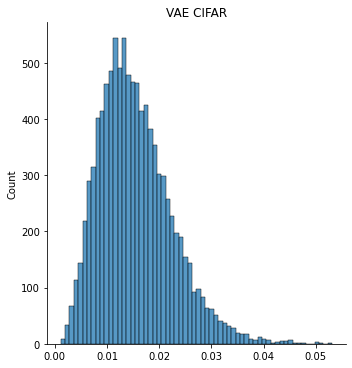

In [10]:
# plot the distribution of reconstruction errors

sns.displot(reconstruction_errors)
plt.title('VAE CIFAR')
plt.savefig('./tmp/vae_cifar', bbox_inches='tight')
plt.show()